In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [2]:

import xgboost as xgb
import catboost as cb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
transactions = pd.read_parquet('/kaggle/input/transactions-filtered/transactions_filtered.pqt')

In [4]:
customers = pd.read_parquet('/kaggle/input/customers/customers.parquet')

In [5]:
articles = pd.read_parquet('/kaggle/input/article/articles.parquet')

In [6]:


class CandidateGenerator:
    def __init__(self, transactions):
        self.transactions = transactions
        self.split_data()
        self.group_data()
        self.predict_next_item()
        self.get_popular_items()
        
    def rerank(self, user_output):
        pass

    def split_data(self):
        df = self.transactions
        self.train1 = df.loc[(df["t_dat"] >= datetime.datetime(2020,9,8)) & (df['t_dat'] < datetime.datetime(2020,9,16))]
        self.train2 = df.loc[(df["t_dat"] >= datetime.datetime(2020,9,1)) & (df['t_dat'] < datetime.datetime(2020,9,8))]
        self.train3 = df.loc[(df["t_dat"] >= datetime.datetime(2020,8,23)) & (df['t_dat'] < datetime.datetime(2020,9,1))]
        self.train4 = df.loc[(df["t_dat"] >= datetime.datetime(2020,8,15)) & (df['t_dat'] < datetime.datetime(2020,8,23))]

    def group_data(self):
        self.positive_items_per_user1 = self.train1.groupby(['customer_id'])['article_id'].apply(list)
        self.positive_items_per_user2 = self.train2.groupby(['customer_id'])['article_id'].apply(list)
        self.positive_items_per_user3 = self.train3.groupby(['customer_id'])['article_id'].apply(list)
        self.positive_items_per_user4 = self.train4.groupby(['customer_id'])['article_id'].apply(list)

    def predict_next_item(self):
        self.train_all = self.make_train_all()
        self.train_all = self.train_all.sort_values(['customer_id', 't_dat'])
        self.train_all['next_item'] = self.train_all.groupby('customer_id')['article_id'].shift(-1)

        pairs = self.train_all.dropna(subset=['next_item'])
        pair_counts = pairs.groupby(['article_id', 'next_item']).size().reset_index(name='count')

        self.pred_next = {}
        for item, group in pair_counts.groupby('article_id'):
            total = group['count'].sum()
            most_common = group.loc[group['count'].idxmax()]
            ratio = most_common['count'] / total
            if total >= 5 and ratio >= 0.1:
                self.pred_next[item] = most_common['next_item']

    def get_popular_items(self):
        df = self.train_all.copy()
        end_date = df['t_dat'].max()
        df['pop_factor'] = (end_date - df['t_dat']).dt.days
        df['pop_factor'] = 1 / df['pop_factor'].replace(0, 1)
        popular_items_group = df.groupby('article_id')['pop_factor'].sum()
        self.popular_items = popular_items_group.sort_values(ascending=False).index.tolist()

    def predict(self, users, model=None):
        positive_items_per_user1 = self.positive_items_per_user1
        positive_items_per_user2 = self.positive_items_per_user2
        positive_items_per_user3 = self.positive_items_per_user3
        positive_items_per_user4 = self.positive_items_per_user4
        pred_next = self.pred_next
        popular_items = self.popular_items
        candidate_data = []

        for user in tqdm(users, desc="Generating candidates"):
            user_output = []
            if user in positive_items_per_user1:
                user_output += list(Counter(positive_items_per_user1[user]).keys())[:12]
            if user in positive_items_per_user2:
                user_output += list(Counter(positive_items_per_user2[user]).keys())[:12]
            if user in positive_items_per_user3:
                user_output += list(Counter(positive_items_per_user3[user]).keys())[:12]
            if user in positive_items_per_user4:
                user_output += list(Counter(positive_items_per_user4[user]).keys())[:12]

            user_output = list(dict.fromkeys(user_output))

            next_preds = [pred_next[item] for item in user_output
                          if item in pred_next and pred_next[item] not in user_output]
            user_output += next_preds

            user_output += list(popular_items[:24 - len(user_output)])
            user_output = list(dict.fromkeys(user_output))
            
            top_items = self.rerank(user_output, model)

            for article in top_items:
                candidate_data.append({'customer_id': user, 'article_id': int(article)})

        return pd.DataFrame(candidate_data)



    def ap_at_k(self,recommended, truths, K=12):
        recommended = list(dict.fromkeys(recommended))[:K]
        if not truths:
            return 0.0
        tp, ap_sum = 0, 0.0
        for k, item in enumerate(recommended, start=1):
            if item in truths:
                tp += 1
                ap_sum += tp / k
        return ap_sum / min(len(truths), K)

    def show_map12(self, test_data,model=None, K=12):
        
        users = test_data['customer_id'].unique()
        y_pred = self.predict(users,model)
    
        
        truth_dict = test_data.groupby('customer_id')['article_id'].apply(set).to_dict()
    
        
    
        
        ap_values = []
        for uid, group in y_pred.groupby('customer_id'):
            recs = group['article_id'].tolist()
            truths = truth_dict.get(uid, set())
            ap_values.append(self.ap_at_k(recs, truths, K))
    
        
        map_score = np.mean(ap_values)
        print(f"MAP@{K} Score: {map_score:.4f}")

  



In [7]:
class RuleBasedCandidateGenerator(CandidateGenerator):
    
    def make_train_all(self):
        return pd.concat([self.train1, self.train2, self.train3, self.train4], axis=0)
        
    def rerank(self, user_output,model):
        return user_output

In [8]:
class MlBasedCandidateGenerator(CandidateGenerator):
    
    def make_train_all(self):
        return pd.concat([self.train1, self.train2, self.train3], axis=0)
        
    def rerank(self, user_output,model):
        scored_items = []
        for article in list(dict.fromkeys(user_output)):
            score = model.predict(user, article)
            scored_items.append((article, score))
        return sorted(scored_items, key=lambda x: x[1], reverse=True)[:12]

    
       
    def make_candidate(self):
        positive_items_per_user1 = self.positive_items_per_user1
        positive_items_per_user2 = self.positive_items_per_user2
        positive_items_per_user3 = self.positive_items_per_user3
        users = self.train4['customer_id'].unique()
    
        pred_next = self.pred_next
        popular_items = self.popular_items
        candidate_data = []
    
        for user in tqdm(users, desc="Generating candidates"):
            user_output = []
            if user in positive_items_per_user1:
                user_output += list(Counter(positive_items_per_user1[user]).keys())[:12]
            if user in positive_items_per_user2:
                user_output += list(Counter(positive_items_per_user2[user]).keys())[:12]
            if user in positive_items_per_user3:
                user_output += list(Counter(positive_items_per_user3[user]).keys())[:12]
    
            user_output = list(dict.fromkeys(user_output))
    
            next_preds = [
                pred_next[item] for item in user_output
                if item in pred_next and pred_next[item] not in user_output and pred_next[item] is not None
            ]
            user_output += next_preds
    
            user_output += list(popular_items[:12 - len(user_output)])
    
            for article in list(dict.fromkeys(user_output))[:12]:
                if article is not None:
                    candidate_data.append({
                        'customer_id': str(user),
                        'article_id': str(article)
                    })
    
        return pd.DataFrame(candidate_data)

    def make_supervised_dataset(self, customers, articles):
        actual_purchases = self.train4[['customer_id', 'article_id']].copy()
        candidates = self.make_candidate()
    
        actual_purchases['customer_id'] = actual_purchases['customer_id'].astype(str)
        actual_purchases['article_id'] = actual_purchases['article_id'].astype(str)
        candidates['customer_id'] = candidates['customer_id'].astype(str)
        candidates['article_id'] = candidates['article_id'].astype(str)
    

        actual_purchases['purchased'] = 1
    
        data = pd.merge(
            candidates,
            actual_purchases,
            on=['customer_id', 'article_id'],
            how='left'
        )
    
        data['purchased'].fillna(0, inplace=True)
        data['purchased'] = data['purchased'].astype(int)
    

    
        return self.add_features(data, customers, articles)

    
    

    
    def add_features(self,transactions,customers,articles):
        
        
        
        transactions['customer_id'] = transactions['customer_id'].astype(str)
        customers['customer_id'] = customers['customer_id'].astype(str)
    
        transactions['article_id'] = transactions['article_id'].astype(str)
        articles['article_id'] = articles['article_id'].astype(str)

        transactions = pd.merge(transactions, customers, on='customer_id', how='left')
        transactions = pd.merge(transactions, articles, on='article_id', how='left')
        
        
    
        return transactions

In [9]:
%%time
mcg=MlBasedCandidateGenerator(transactions)

CPU times: user 17.6 s, sys: 290 ms, total: 17.9 s
Wall time: 17.9 s


In [10]:
%%time
data=mcg.make_supervised_dataset(customers,articles)

Generating candidates: 100%|██████████| 74734/74734 [00:06<00:00, 10756.53it/s]


CPU times: user 11.2 s, sys: 1.2 s, total: 12.4 s
Wall time: 12.3 s


In [11]:
%%time
rcg=RuleBasedCandidateGenerator(transactions)

CPU times: user 18.9 s, sys: 127 ms, total: 19 s
Wall time: 19 s


In [12]:
test_data=transactions.loc[(transactions["t_dat"] >= datetime.datetime(2020,9,16))]

In [13]:
%%time
rcg.show_map12(test_data)

Generating candidates: 100%|██████████| 68984/68984 [00:08<00:00, 7678.48it/s] 


MAP@12 Score: 0.0260
CPU times: user 27.2 s, sys: 3.54 s, total: 30.8 s
Wall time: 30.7 s


In [14]:
%%time
rcg.predict(test_data['customer_id'].unique())

Generating candidates: 100%|██████████| 68984/68984 [00:08<00:00, 8395.91it/s] 


CPU times: user 16.5 s, sys: 2.51 s, total: 19 s
Wall time: 19 s


,customer_id,article_id
0,000fb6e772c5d0023892065e659963da90b1866035558e...,884319006
1,000fb6e772c5d0023892065e659963da90b1866035558e...,762846026
2,000fb6e772c5d0023892065e659963da90b1866035558e...,919273004
3,000fb6e772c5d0023892065e659963da90b1866035558e...,927922002
4,000fb6e772c5d0023892065e659963da90b1866035558e...,611415034
...,...,...
12791688,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,918522001
12791689,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,448509014
12791690,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,915529003
12791691,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,706016001


In [15]:
df=data.copy()

In [16]:
df.dropna(inplace=True)

In [17]:
df.drop([
    'postal_code','FN','Active','product_code','prod_name','section_name','index_code','graphical_appearance_no','department_name','department_no','garment_group_no','section_no','index_group_no','product_type_no','colour_group_code','perceived_colour_value_id','perceived_colour_master_id','detail_desc','product_type_name','garment_group_name','colour_group_name','graphical_appearance_name','perceived_colour_master_name','product_group_name','index_name'
], inplace=True, axis=1)

In [18]:
df

,customer_id,article_id,purchased,club_member_status,fashion_news_frequency,age,perceived_colour_value_name,index_group_name
24,0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...,924243001,0,ACTIVE,Regularly,22.0,Dusty Light,Ladieswear
25,0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...,875272001,0,ACTIVE,Regularly,22.0,Medium Dusty,Divided
26,0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...,909370001,0,ACTIVE,Regularly,22.0,Dusty Light,Ladieswear
27,0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...,751471001,0,ACTIVE,Regularly,22.0,Dark,Ladieswear
28,0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...,865799006,0,ACTIVE,Regularly,22.0,Dusty Light,Ladieswear
...,...,...,...,...,...,...,...,...
896631,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,915529003,0,ACTIVE,Regularly,45.0,Dark,Ladieswear
896632,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,706016001,0,ACTIVE,Regularly,45.0,Dark,Divided
896633,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,915526001,0,ACTIVE,Regularly,45.0,Dusty Light,Ladieswear
896634,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,923758001,0,ACTIVE,Regularly,45.0,Light,Ladieswear


In [19]:



categorical_cols = df.select_dtypes(include=['object', 'category']).columns


exclude_cols = ['customer_id', 'article_id']


categorical_cols = [col for col in categorical_cols if col not in exclude_cols]


df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [20]:
df_encoded

,customer_id,article_id,purchased,age,club_member_status_PRE-CREATE,fashion_news_frequency_NONE,fashion_news_frequency_Regularly,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
24,0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...,924243001,0,22.0,0,0,1,0,1,0,0,0,0,0,1,0,0
25,0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...,875272001,0,22.0,0,0,1,0,0,0,0,1,0,1,0,0,0
26,0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...,909370001,0,22.0,0,0,1,0,1,0,0,0,0,0,1,0,0
27,0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...,751471001,0,22.0,0,0,1,1,0,0,0,0,0,0,1,0,0
28,0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...,865799006,0,22.0,0,0,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896631,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,915529003,0,45.0,0,0,1,1,0,0,0,0,0,0,1,0,0
896632,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,706016001,0,45.0,0,0,1,1,0,0,0,0,0,1,0,0,0
896633,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,915526001,0,45.0,0,0,1,0,1,0,0,0,0,0,1,0,0
896634,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,923758001,0,45.0,0,0,1,0,0,1,0,0,0,0,1,0,0


In [21]:


purchase_count = df_encoded.groupby('customer_id')['purchased'].sum().reset_index()
purchase_count.rename(columns={'purchased':'purchase_count'}, inplace=True)

article_diversity = df_encoded.groupby('customer_id')['article_id'].nunique().reset_index()
article_diversity.rename(columns={'article_id':'article_diversity'}, inplace=True)

repurchase = df_encoded.groupby(['customer_id','article_id']).size().reset_index(name='count')
repurchase_rate = repurchase.groupby('customer_id')['count'].apply(lambda x: (x>1).mean()).reset_index(name='repeat_purchase_ratio')

colour_cols = [c for c in df_encoded.columns if c.startswith('perceived_colour_value_name')]
colour_diversity = df_encoded.groupby('customer_id')[colour_cols].sum().gt(0).sum(axis=1).reset_index(name='colour_diversity')

category_cols = [c for c in df_encoded.columns if c.startswith('index_group_name')]
category_diversity = df_encoded.groupby('customer_id')[category_cols].sum().gt(0).sum(axis=1).reset_index(name='category_diversity')

article_popularity = df_encoded.groupby('article_id')['purchased'].sum().reset_index()
article_popularity.rename(columns={'purchased':'article_popularity'}, inplace=True)

unique_customer_count = df_encoded.groupby('article_id')['customer_id'].nunique().reset_index()
unique_customer_count.rename(columns={'customer_id':'unique_customer_count'}, inplace=True)

df_features = df_encoded.merge(purchase_count, on='customer_id')
df_features = df_features.merge(article_diversity, on='customer_id')
df_features = df_features.merge(repurchase_rate, on='customer_id')
df_features = df_features.merge(colour_diversity, on='customer_id')
df_features = df_features.merge(category_diversity, on='customer_id')
df_features = df_features.merge(article_popularity, on='article_id')
df_features = df_features.merge(unique_customer_count, on='article_id')

print(df_features.head())


                                         customer_id article_id  purchased  \
0  0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...  924243001          0   
1  001eccaf68dc46d3068308771c69ab9103972f4f743c94...  924243001          0   
2  0025b31255df18a12793925c2df47e64247c5a1ee8989d...  924243001          0   
3  002d04cb323607cf2db895ae8d74e6b020f9ba77e02ef6...  924243001          0   
4  0050be3089108d675eaa2e173b9a045a33ee7c25acfafc...  924243001          0   

    age  club_member_status_PRE-CREATE  fashion_news_frequency_NONE  \
0  22.0                              0                            0   
1  20.0                              0                            0   
2  52.0                              0                            0   
3  51.0                              0                            0   
4  58.0                              0                            0   

   fashion_news_frequency_Regularly  perceived_colour_value_name_Dark  \
0                              

In [22]:
import statsmodels.api as sm

X = df_features.drop(columns=['customer_id', 'article_id', 'purchased'])
y = df_features['purchased']

X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()



         Current function value: 0.025278
         Iterations: 35


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [23]:
p_values=[[col,pvalue] for col,pvalue in result.pvalues.items()]
    


In [24]:
p_values.sort(key=lambda x:x[1])

In [25]:
p_values

[['purchase_count', 0.0],
 ['unique_customer_count', 5.604224084990033e-294],
 ['article_popularity', 3.301007338521734e-148],
 ['repeat_purchase_ratio', 3.555831291226263e-54],
 ['category_diversity', 4.2031171390213426e-46],
 ['colour_diversity', 7.218010025822133e-11],
 ['const', 5.824089591646193e-07],
 ['index_group_name_Sport', 5.631195381373192e-05],
 ['perceived_colour_value_name_Light', 0.00022329385189239826],
 ['index_group_name_Ladieswear', 0.0004623551692929793],
 ['perceived_colour_value_name_Medium', 0.0007802287413327918],
 ['index_group_name_Divided', 0.0011818050467773782],
 ['perceived_colour_value_name_Medium Dusty', 0.031060220239310522],
 ['perceived_colour_value_name_Dark', 0.11182240716026648],
 ['club_member_status_PRE-CREATE', 0.17642085699647403],
 ['perceived_colour_value_name_Dusty Light', 0.18776917187253228],
 ['index_group_name_Menswear', 0.3178361487721313],
 ['age', 0.4604905229382277],
 ['fashion_news_frequency_Regularly', 0.5951012312400903],
 ['arti

In [26]:
for col,p_value in p_values:
    if p_value<=0.05:
        print(f'{col}: {p_value:.2f}')

purchase_count: 0.00
unique_customer_count: 0.00
article_popularity: 0.00
repeat_purchase_ratio: 0.00
category_diversity: 0.00
colour_diversity: 0.00
const: 0.00
index_group_name_Sport: 0.00
perceived_colour_value_name_Light: 0.00
index_group_name_Ladieswear: 0.00
perceived_colour_value_name_Medium: 0.00
index_group_name_Divided: 0.00
perceived_colour_value_name_Medium Dusty: 0.03


In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# customer_id와 article_id 제외
X = df_features.drop(['customer_id', 'article_id'], axis=1)

# 상수항 추가
X = add_constant(X)
vif_list = [[X.columns[i], variance_inflation_factor(X.values, i)] for i in range(X.shape[1])]
print(vif_list)

[['const', 3443.57672028268], ['purchased', 1.1865320982643783], ['age', 1.003055490997624], ['club_member_status_PRE-CREATE', 1.0013206459281219], ['fashion_news_frequency_NONE', 1.7594356984708943], ['fashion_news_frequency_Regularly', 1.7594681560304286], ['perceived_colour_value_name_Dark', 55.664375462550844], ['perceived_colour_value_name_Dusty Light', 51.984801270209594], ['perceived_colour_value_name_Light', 40.53726603660199], ['perceived_colour_value_name_Medium', 1.723809452849982], ['perceived_colour_value_name_Medium Dusty', 6.153963397906654], ['perceived_colour_value_name_Undefined', 1.0264366962343232], ['index_group_name_Divided', 35.89395163062872], ['index_group_name_Ladieswear', 48.1064167972702], ['index_group_name_Menswear', 3.248508289617472], ['index_group_name_Sport', 19.577613328962787], ['purchase_count', 2.2922604112714002], ['article_diversity', 1.1314812012253117], ['repeat_purchase_ratio', 2.0790846472499207], ['colour_diversity', 1.1747361143654056], ['c

In [29]:
cols=[]

In [30]:
for (col,p_value),(_,vif) in zip(p_values,vif_list):
    if p_value<=0.05 and vif<10:
        print(f'{col}: {p_value:.2f}')
        cols.append(col)

unique_customer_count: 0.00
article_popularity: 0.00
repeat_purchase_ratio: 0.00
category_diversity: 0.00
colour_diversity: 0.00
index_group_name_Ladieswear: 0.00
perceived_colour_value_name_Medium: 0.00
index_group_name_Divided: 0.00


In [31]:
df_features[cols].describe()

,unique_customer_count,article_popularity,repeat_purchase_ratio,category_diversity,colour_diversity,index_group_name_Ladieswear,perceived_colour_value_name_Medium,index_group_name_Divided
count,400934.000000,400934.000000,400934.000000,400934.000000,400934.000000,400934.000000,400934.000000,400934.000000
mean,24338.432937,62.311196,0.001086,2.926649,3.180509,0.728225,0.003220,0.175341
std,11054.223852,74.206906,0.010590,0.409345,0.432140,0.444875,0.056654,0.380259
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,21662.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000
50%,29268.000000,1.000000,0.000000,3.000000,3.000000,1.000000,0.000000,0.000000
75%,31500.000000,111.000000,0.000000,3.000000,3.000000,1.000000,0.000000,0.000000
max,32491.000000,210.000000,0.363636,4.000000,6.000000,1.000000,1.000000,1.000000


In [32]:
df=df_features[cols]

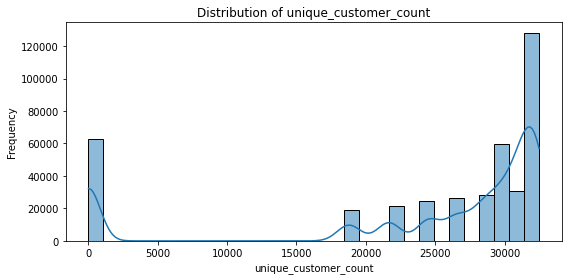

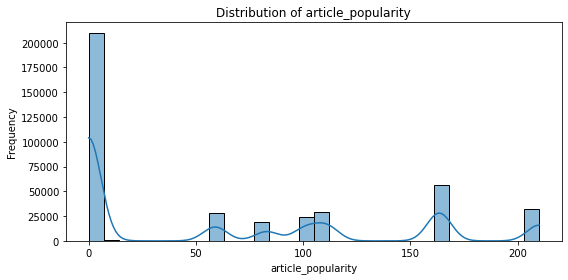

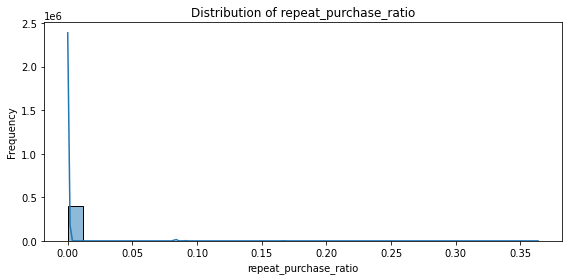

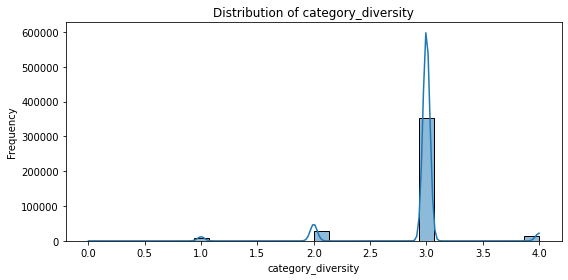

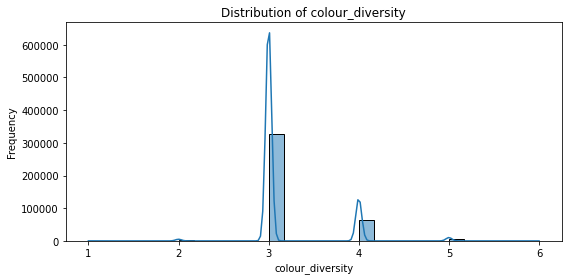

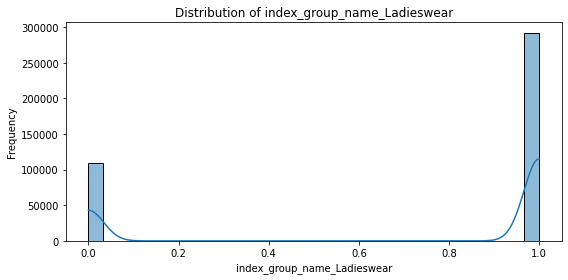

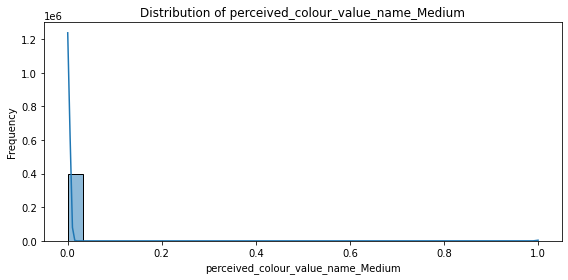

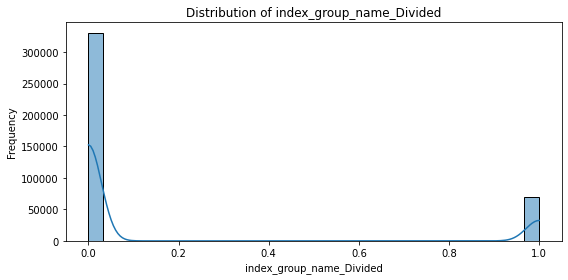

In [33]:
numeric_cols = df.select_dtypes(include=['number']).columns


for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [34]:
df[['repeat_purchase_ratio', 'category_diversity', 'colour_diversity']]

,repeat_purchase_ratio,category_diversity,colour_diversity
0,0.000000,3,4
1,0.000000,3,3
2,0.000000,3,3
3,0.000000,3,3
4,0.000000,3,4
...,...,...,...
400929,0.000000,3,3
400930,0.083333,3,4
400931,0.000000,4,4
400932,0.000000,2,3


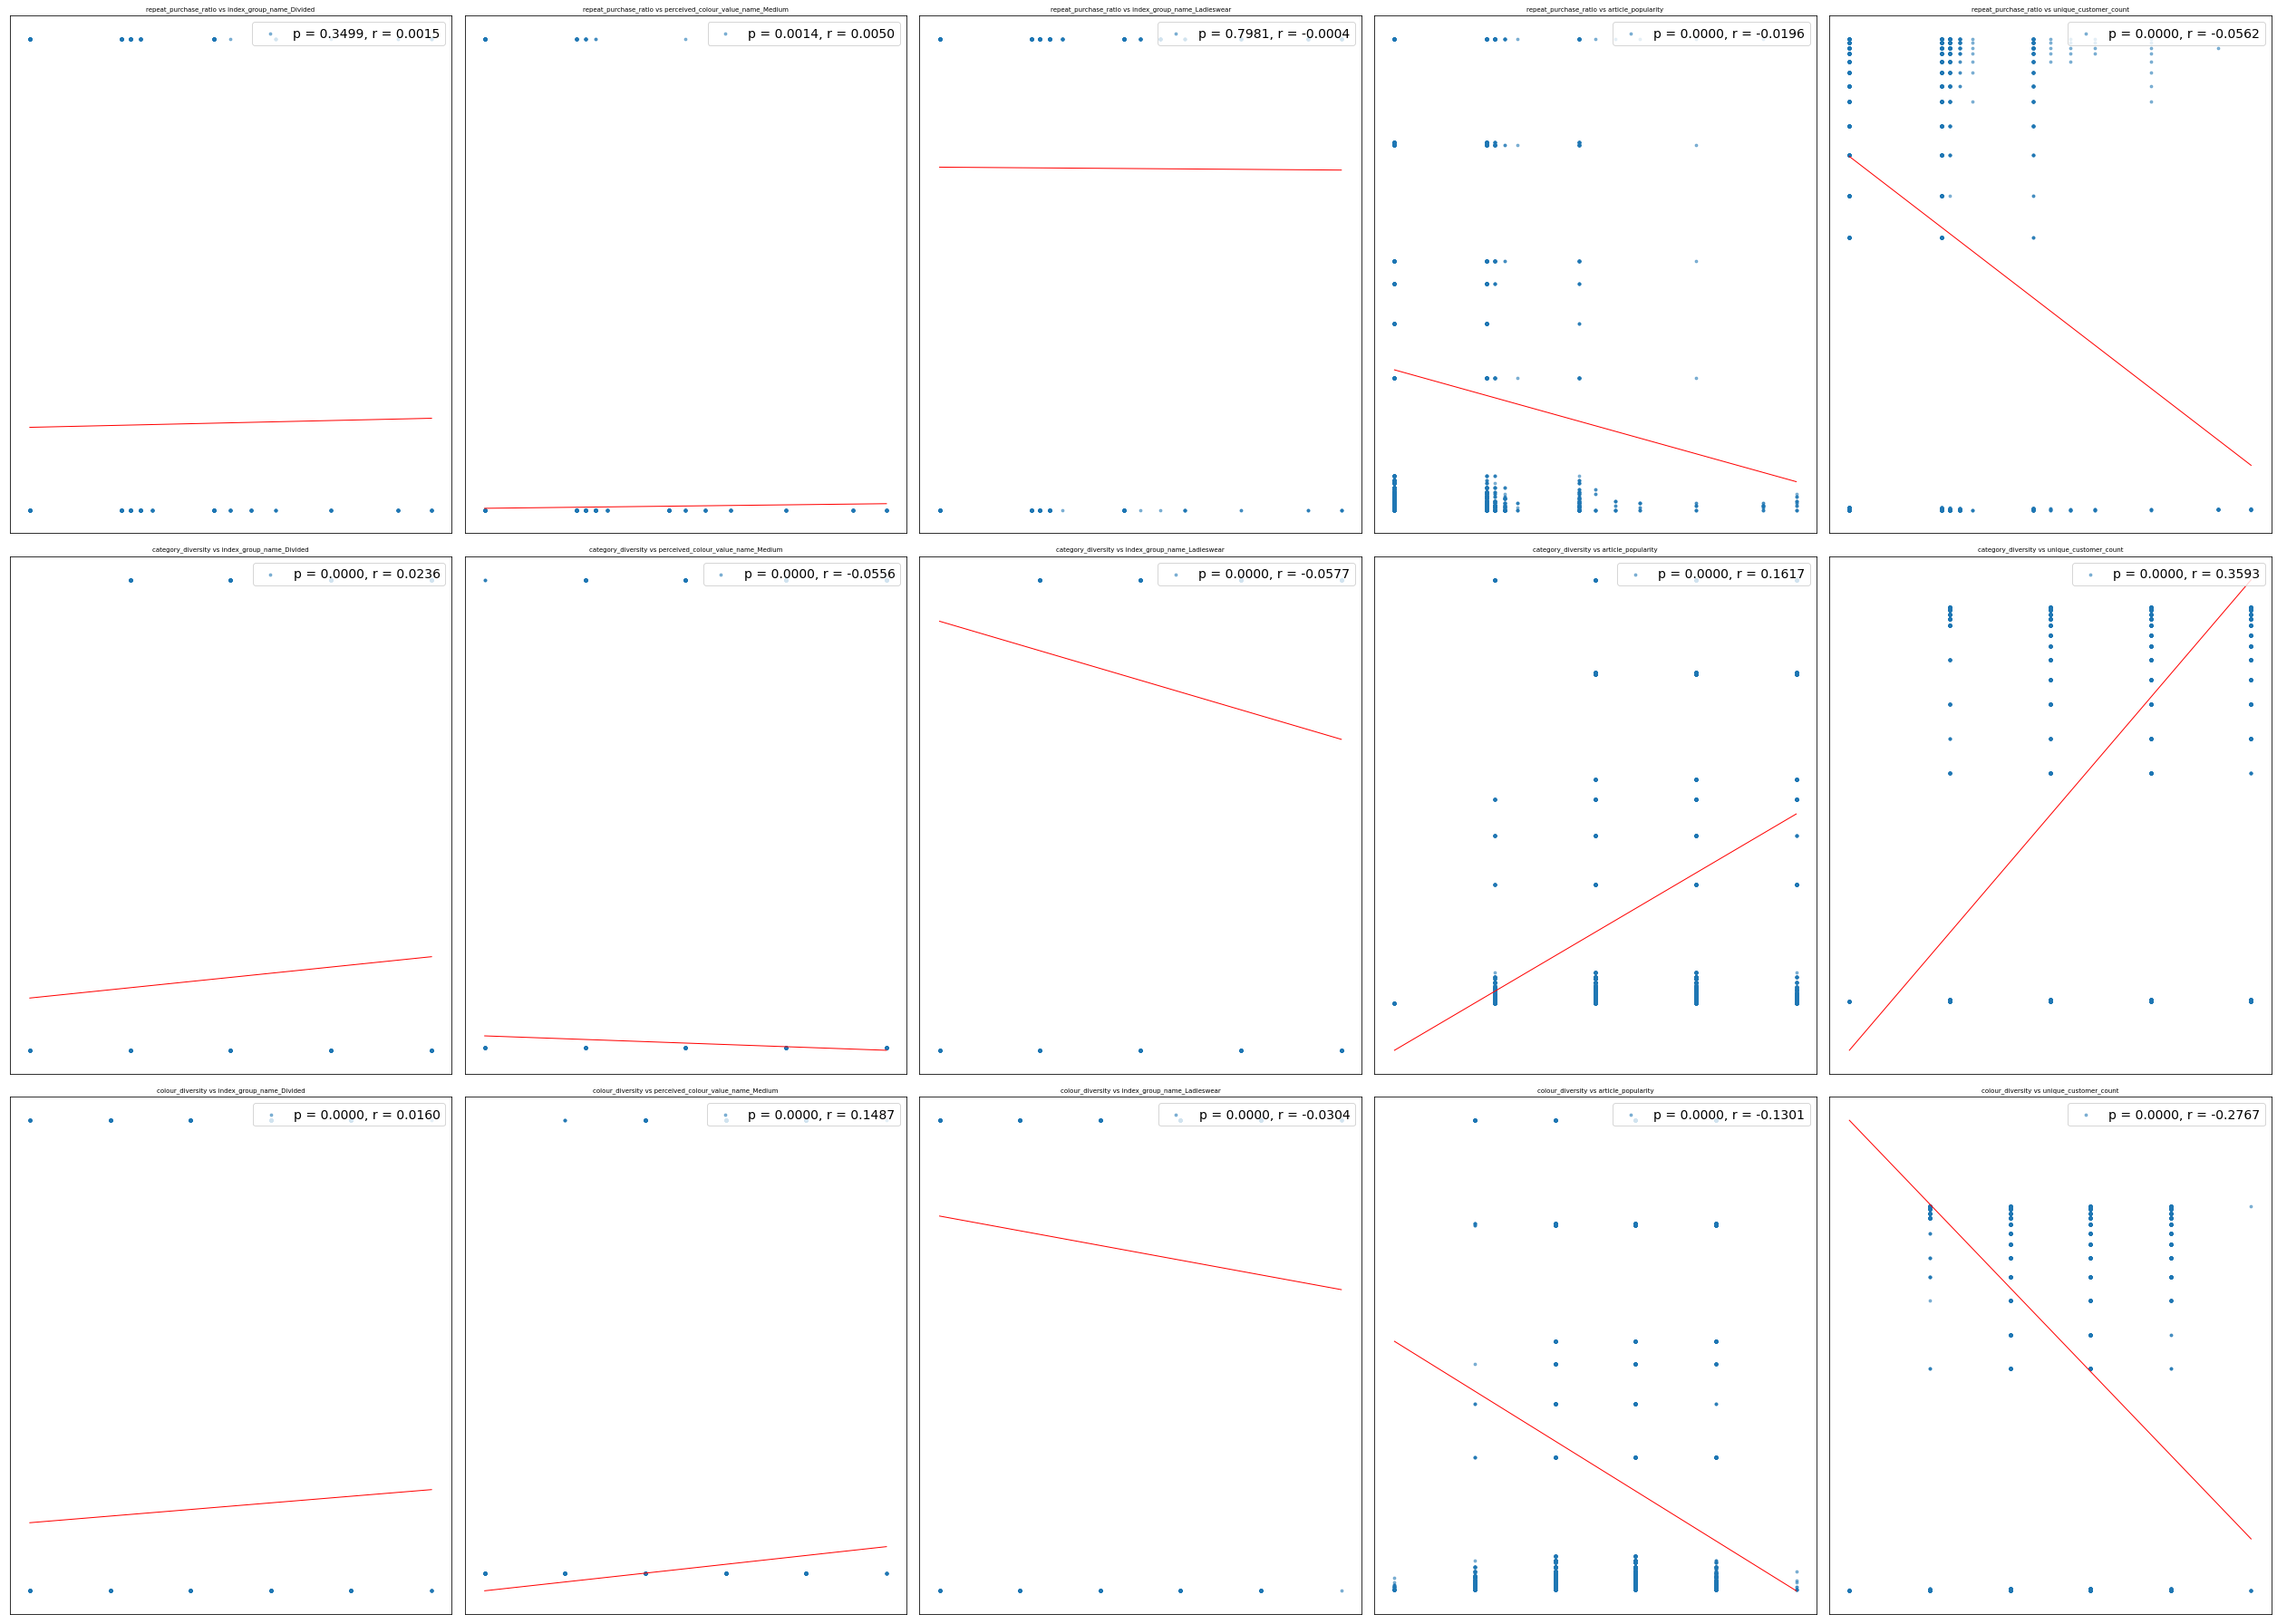

In [35]:
import itertools
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

user_vars = ['repeat_purchase_ratio', 'category_diversity', 'colour_diversity']

article_vars = ['index_group_name_Divided',
                'perceived_colour_value_name_Medium',
                'index_group_name_Ladieswear',
                'article_popularity',
                'unique_customer_count']

fig, axes = plt.subplots(len(user_vars), len(article_vars), figsize=(35, 25))

for i, u in enumerate(user_vars):
    for j, a in enumerate(article_vars):
        X = df[[u]].dropna()
        Y = df[[a]].dropna()
        df_pair = df[[u, a]].dropna()

        cca = CCA(n_components=1)
        X_c, Y_c = cca.fit_transform(df_pair[[u]], df_pair[[a]])

        # 산점도
        axes[i][j].scatter(X_c, Y_c, alpha=0.5, s=8)

        # 회귀선 추가
        model = LinearRegression().fit(X_c, Y_c)
        x_vals = np.linspace(X_c.min(), X_c.max(), 100).reshape(-1, 1)
        y_vals = model.predict(x_vals)
        axes[i][j].plot(x_vals, y_vals, color='red', linewidth=1)

        # p-value 계산
        X_c_sm = sm.add_constant(X_c)
        ols_model = sm.OLS(Y_c, X_c_sm).fit()
        pval = ols_model.pvalues[1]

        # r-value 계산
        r_val = np.corrcoef(X_c.T, Y_c.T)[0, 1]

        # 레전드 추가
        axes[i][j].legend([f'p = {pval:.4f}, r = {r_val:.4f}'], loc='upper right', fontsize=14)

        axes[i][j].set_title(f'{u} vs {a}', fontsize=7)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

plt.tight_layout()
plt.show()

In [36]:
X=df

In [37]:
y

0         0
1         0
2         0
3         0
4         0
         ..
400929    0
400930    0
400931    0
400932    0
400933    0
Name: purchased, Length: 400934, dtype: int64

In [38]:
X,y

(        unique_customer_count  article_popularity  repeat_purchase_ratio  \
 0                       32491                   0               0.000000   
 1                       32491                   0               0.000000   
 2                       32491                   0               0.000000   
 3                       32491                   0               0.000000   
 4                       32491                   0               0.000000   
 ...                       ...                 ...                    ...   
 400929                      1                   0               0.000000   
 400930                      1                   0               0.083333   
 400931                      1                   0               0.000000   
 400932                      1                   0               0.000000   
 400933                      1                   0               0.000000   
 
         category_diversity  colour_diversity  index_group_name_Ladieswear

In [39]:
from sklearn.ensemble import RandomForestRegressor  
import pandas as pd


model = RandomForestRegressor(random_state=42)
model.fit(X, y)


importances = model.feature_importances_
feature_names = X.columns


importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

                              feature  importance
0               unique_customer_count    0.344365
1                  article_popularity    0.336669
2               repeat_purchase_ratio    0.161896
4                    colour_diversity    0.061774
3                  category_diversity    0.052706
5         index_group_name_Ladieswear    0.020085
7            index_group_name_Divided    0.017269
6  perceived_colour_value_name_Medium    0.005235


In [40]:

selected_features = [
    'unique_customer_count',
    'colour_diversity',
    'article_popularity',
    'category_diversity'
]


X = X[selected_features]

In [41]:
# y와 X에서 공통된 인덱스만 남기기
X_aligned, y_aligned = X.align(y, join='inner', axis=0)

# 로지스틱 회귀 모델 적합
X_aligned = sm.add_constant(X_aligned)
model = sm.Logit(y_aligned, X_aligned).fit()

# 오즈비 계산
odds_ratios = np.exp(model.params)
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.036356
         Iterations 12
const                    0.030934
unique_customer_count    0.999820
colour_diversity         0.889079
article_popularity       1.020258
category_diversity       1.199469
dtype: float64


In [42]:

selected_features = [
    'colour_diversity',
    'article_popularity',
    'category_diversity'
]


X = X[selected_features]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lime.lime_tabular import LimeTabularExplainer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'NaiveBayes': GaussianNB(),
    'KNN': KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob),
        'f1': f1_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred)
    }

explainer = LimeTabularExplainer(X_train.values, feature_names=X.columns.tolist(), class_names=['0', '1'], discretize_continuous=True)
lime_exp = explainer.explain_instance(X_test.values[0], models['RandomForest'].predict_proba, num_features=5)
lime_exp.show_in_notebook()
print(results)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
